# NSL Notebook 10

In [1]:
from default import *

## Exercise 10.1

**Traveling Salesman Problem | Simulated Annealing Algo** 

Dumpy temperature parameters choice:

* initial temperature $1.1$


* final temperature $0.1$


* temperature step $0.1$ (every $100$ metropolis steps)

The main idea is not to start from **Population** (ensemble of random paths) and then sort using path distance. But start from a single **Tour** (path), mutate it, and then select the new path or not, using **Metropolis algo** with a Boltzmann probability where **cost function** is the distance gap between parent-child paths and the temperature a dumpy parameter to achieve convergence. So theoretically after tot steps, if the temperature is constantly decreased, the paths selected by the metropolis algo will always be shorter, reaching a stable value (the best path) when $T\simeq 0$ 

### Exercise 10.1.1

Solve **TSP** problem for 32 cities on circle.

Below the results, I plotted the trend of the best path at each optimization steps $L1$, after $1000$ metropolis steps and so after $10$ temperature changes.

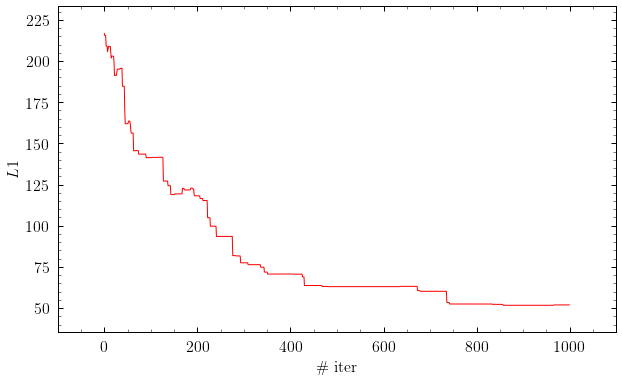

In [2]:
fig, ax = plt.subplots(figsize=(10,6))

dfb = pd.read_csv('bL1OC.out', header=None, names=['L1'])

dfb['L1'].plot.line(ls='-', c='r', ax=ax);

ax.set_ylabel('$L1$');
ax.set_xlabel('\# iter');

Below, instead, an HTML5 animation comparison between one of the initial random configurations, and the best path at the end of optimization.

In [4]:
from matplotlib.animation import FuncAnimation
from time import sleep

fig, (axb, axa) = plt.subplots(1,2, figsize=(10,5));

dfb = pd.read_csv('circle.tsv', 
                  header=None, 
                  sep='\t', 
                  names=['x','y']);
dfa = pd.read_csv('OC.csv', 
                  header=None, 
                  sep=',', 
                  names=['x','y']);

xb = [dfb['x'][0]]
yb = [dfb['y'][0]]
xa = [dfa['x'][0]]
ya = [dfa['y'][0]]

def func(npt, *fargs):
    xb.append(npt[0][0])
    yb.append(npt[0][1])
    xa.append(npt[1][0])
    ya.append(npt[1][1])
    axb.plot(xb,yb, '-r');
    axa.plot(xa,ya, '-b');
    xb.pop(0)
    yb.pop(0)
    xa.pop(0)
    ya.pop(0)
    
def init_func():
    axb.scatter(dfb['x'], dfb['y'], marker='.', color='k');
    axa.scatter(dfa['x'], dfa['y'], marker='.', color='k');
    sleep(1);
    
    
frames = []
for ptb, pta in zip(np.asarray(dfb), np.asarray(dfa)):
    frames.append((ptb, pta))
    
anim = FuncAnimation(fig, func, frames, init_func, interval=300);
plt.close(fig=fig)

from IPython.display import HTML
HTML(anim.to_html5_video())

## Exercise 10.1.2

Solve **TSP** problem for 32 cities inside a square.

Below the results, I plotted the trend of the best path at each optimization steps $L1$, after $1000$ metropolis steps and so after $10$ temperature changes.

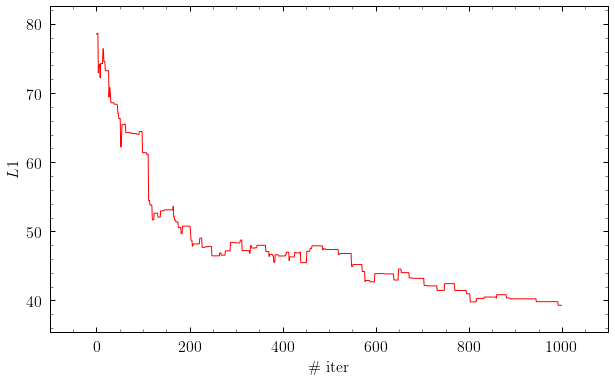

In [3]:
fig, ax = plt.subplots(figsize=(10,6))

dfb = pd.read_csv('bL1IS.out', header=None, names=['L1'])

dfb['L1'].plot.line(ls='-', c='r', ax=ax);

ax.set_ylabel('$L1$');
ax.set_xlabel('\# iter');

Below, instead, an HTML5 animation comparison between one of the initial random configurations, and the best path at the end of optimization.

In [5]:
from matplotlib.animation import FuncAnimation
from time import sleep

fig, (axb, axa) = plt.subplots(1,2, figsize=(10,5));

dfb = pd.read_csv('square.tsv', 
                  header=None, 
                  sep='\t', 
                  names=['x','y']);
dfa = pd.read_csv('IS.csv', 
                  header=None, 
                  sep=',', 
                  names=['x','y']);

xb = [dfb['x'][0]]
yb = [dfb['y'][0]]

xa = [dfa['x'][0]]
ya = [dfa['y'][0]]

def func(npt, *fargs):
    xb.append(npt[0][0])
    yb.append(npt[0][1])
    xa.append(npt[1][0])
    ya.append(npt[1][1])
    axb.plot(xb,yb, '-r');
    axa.plot(xa,ya, '-b');
    xb.pop(0)
    yb.pop(0)
    xa.pop(0)
    ya.pop(0)
    
def init_func():
    axb.scatter(dfb['x'], dfb['y'], marker='.', color='k');
    axa.scatter(dfa['x'], dfa['y'], marker='.', color='k');
    sleep(1);
    
    
frames = []
for ptb, pta in zip(np.asarray(dfb), np.asarray(dfa)):
    frames.append((ptb, pta))
    
anim = FuncAnimation(fig, func, frames, init_func, interval=300, blit=False);
plt.close(fig=fig)

from IPython.display import HTML
HTML(anim.to_html5_video())

## Excercise 10.2

**Traveling Salesman Problem | MPI Genetic Algo**

We would like to parallalize the **TSP (GA)** using the **open-MPI** library (an **MPI** open source implementation). The idea is: 

* start $4$ different **workers**, each with a different random seed, that will execute an indipendent **TSP** optimizazion using GA
* after some simulation time, swap random, the optimizated **Population** (paths) between workers
* continue with these indipendent optimizaztions and then random results exchange, until a stable/best path is reached

Theoretically, using different input seeds, and exchanging the results between workers, the performance of the algorithm should improve cause simply there are more mutations possibilities that can be explored.

Clarification: since my **TSP** implementation is strongly stdlib object dependent, using only **open-MPI** library to exchange **Population** (`std::vector`) object between workers would have been a nightmare. So inspired by this [guide](https://rkumar310.wordpress.com/2013/12/16/sendreceive-vector-of-objects-using-boost-mpi/), I decided to use the `boost` library wrapper around open-mpi to serialize my objects and then be able to pass them using send/receive std functions. This would create little differences inside the original class, that should have been compiled with different options, so I decided to create a **TSP-mpi** class to separate them, and so also a **cpp-mpi** folder.

### Excercise 10.2.1

Solve **TSP** problem for 32 cities on circle.

Summing up, below the best path distance results at each step, for each worker, with a total steps $50$ and total results exchange $5$ (one random exchange every $10$ steps).

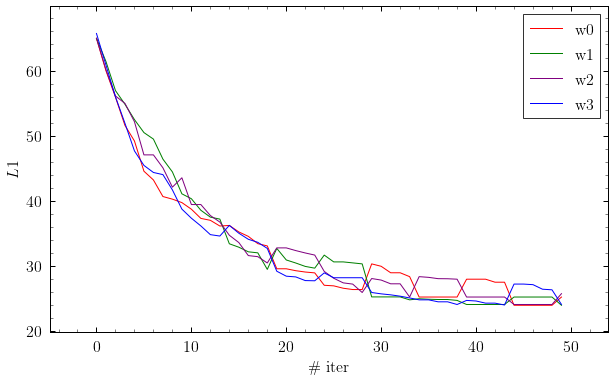

In [6]:
fig, ax = plt.subplots(figsize=(10,6))

cc = ['r', 'green', 'purple', 'b']

df = dict()
for i in range(4):
    df[i] = pd.read_csv(f'bL1IS-mpi-{i}.out', header=None, names=['L1'])
    
for i in range(4):
    df[i]['L1'].plot.line(ls='-', c=cc[i], label=f'w{i}', ax=ax);
    
ax.set_ylabel('$L1$');
ax.set_xlabel('\# iter');
ax.legend();

Below, instead, an HTML5 animation comparison between best paths for each worker at the end of optimization.

In [9]:
from matplotlib.animation import FuncAnimation
from time import sleep

fig, ax = plt.subplots(2,2, figsize=(9,9));

cc = ['r', 'green', 'purple', 'b']

ax = np.asarray(ax)
ax = ax.reshape(1,4)[0]

df = dict()
xx = dict()
yy = dict()
for i in range(4):
    df[i] = pd.read_csv(f'IS-mpi-{i}.csv', header=None, names=['x','y']);
    xx[i] = [df[i]['x'][0]]
    yy[i] = [df[i]['y'][0]]


def func(npt, *fargs):
    for i in range(4):
        xx[i].append(npt[i][0])
        yy[i].append(npt[i][1])
        ax[i].plot(xx[i],yy[i], ls='-', c=cc[i]);
        xx[i].pop(0)
        yy[i].pop(0)

def init_func():
    for i in range(4):
        ax[i].scatter(df[i]['x'], df[i]['y'], marker='.', color='k');
    sleep(1);
        
frames = []
for pt0, pt1, pt2, pt3 in zip(np.asarray(df[0]), 
                              np.asarray(df[1]), 
                              np.asarray(df[2]), 
                              np.asarray(df[3])):
    frames.append((pt0, pt1, pt2, pt3))
    
anim = FuncAnimation(fig, func, frames, init_func, interval=300, blit=False);
plt.close(fig=fig)

from IPython.display import HTML
HTML(anim.to_html5_video())